In [1]:
from __future__ import absolute_import, division, print_function

# Full workflow

In [2]:
import copy
import glob
import json
import os
import pickle
import random
import re
import sys
import time
from collections import Counter

import googlemaps
import matplotlib as mpl
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as ss
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline


# Functions

In [3]:
# Find local maxima
def find_local_max(inarr,win=3,style='mode',level=3,**kwargs):
    """
    Find the local maxima in an array.
    
    The input array should be a (NxN) numpy array.
    
    A window of size (win)x(win) is used.
    Window size win needs to be an odd number
    to have a defined center pixel. If win is even, 
    it is autamtically increased by +1.
    
    The output is a mask of size equal to the input array 
    (NxN) with 0, unless a pixel is identified as a maximum.
    
    The maxima are evaluated base on 'style' using 'level'. 
    E.g., for 'style=mode' and 'level=3', a local maximum if 
    found is retained if its value is 3 times the mode of the
    image.
    """
    # check input
    if win%2 == 0:
        win += 1
    # create empty mask
    shp = inarr.shape
    mask = np.zeros(shape=shp)
    # central index of window
    win_idx = int(np.floor(win/2.)) 
    cen_idx = (win_idx,win_idx)
    win_mask = np.zeros(shape=(win,win))
    win_mask[cen_idx] = 1
    comp_mask = win_mask == 0
    val_mask = win_mask == 1
    xlen = len(inarr[:,0])
    ylen = len(inarr[:,1])
    # determine more in array
    inarr_ravel = inarr.ravel()
    tmp_list = np.ndarray.tolist(inarr_ravel)
    if style == 'mean':
        tmp_mode = np.mean(inarr_ravel)
        print('Using MEAN for cutoff: ', tmp_mode)
    elif style == 'median':
        tmp_mode = np.median(inarr_ravel)
        print('Using MEDIAN for cutoff: ', tmp_mode)
    elif style == 'bkg':
        tmp_mode = find_background(inarr,**kwargs)
        print('Using BKG for cutoff: ', tmp_mode)
    else:
        tmp_mode = Counter(tmp_list).most_common(1)[0][0]
        print('Using MODE for cutoff: ', tmp_mode)
    cutoff = level*tmp_mode
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            sub_arr = inarr[xidx-win_idx:xidx+win_idx+1,yidx-win_idx:yidx+win_idx+1]
            if sub_arr.shape != (win,win):
                pass
            else:
                comp_vals = sub_arr[comp_mask]
                mid_val = sub_arr[val_mask]
                check = [False if x < mid_val else True for x in comp_vals]
                if (sum(check) == 0) and (mid_val > cutoff):
                    mask[xidx,yidx] = int(1)
    final_mask = mask == 1
    return final_mask, cutoff


In [4]:
# Determine background
def find_background(inarr,patch=3,method='median',n_samples=50):
    """
    Find the background value in a 2D array.
    
    Randomly sample the array at 'n_samples' locations. Take 
    metric as set by 'style' within square region with side length 
    defined by 'win'. 
    
    Returns background value of array.
    """
    xdim = inarr.shape[0]
    ydim = inarr.shape[1]
    xidx = np.random.randint(0,xdim-1,n_samples)
    yidx = np.random.randint(0,ydim-1,n_samples)
    coords = zip(xidx,yidx)
    bkg_vec = []
    for idx,coord in enumerate(coords):
        tmp_patch = inarr[coord[0]-patch:coord[0]+patch,coord[1]-patch:coord[1]+patch]
        try:
            if method == 'mean':
                tmp_val = np.mean(tmp_patch)
            else:
                tmp_val = np.median(tmp_patch)
            bkg_vec.append(tmp_val)
        except:
            pass
    if method == 'mean':
        return np.nanmean(bkg_vec)
    else:
        return np.nanmedian(bkg_vec)


In [147]:
# determine distance between points
earth_radius_miles = 3956.0
def getKey(item):
    return item[1]


def integrate_peaks(inarr,peaks,threshold):
    mask = np.zeros(inarr.shape)
    tmp_print = True
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            value = inarr[xidx,yidx]
            if value <= threshold:
                pass
            else:
                dist = []
                tmp_dist = []
                for idx,peak in enumerate(peaks):
                    label = idx+1
                    pix_coord = base_coords_map[xidx,yidx]
                    dlon = np.radians(peak[0]) - np.radians(pix_coord[0])
                    dlat = np.radians(peak[1]) - np.radians(pix_coord[1])
                    a = np.square(np.sin(dlat/2.0)) + np.cos(np.radians(peak[1])) * np.cos(np.radians(pix_coord[1])) * np.square(np.sin(dlon/2.0))
                    great_circle_distance = 2 * np.arcsin(np.sqrt(a))
                    d = earth_radius_miles * great_circle_distance
                    tmp_dist.append((label,d))
                    
            
                # find minimum index in list
                tmp_dist_sorted = sorted(tmp_dist, key=getKey)
                # replace elemnt in mask with label
                mask[xidx,yidx] = tmp_dist_sorted[0][0]
    return mask


In [148]:
# determine distance between points
from sklearn.neighbors import NearestNeighbors
def find_neighbors(inarr,peaks,threshold):
    samples = peaks
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(samples)    
    mask = np.zeros(inarr.shape)
    tmp_print = True
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            value = inarr[xidx,yidx]
            if value <= threshold:
                pass
            else:
                out = neigh.kneighbors(base_coords_map[xidx][yidx].reshape(1, -1))    
                mask[xidx,yidx] = out[1][0][0]+1
    return mask


In [149]:
# determine distance between points
def node_dist(inarr,peaks,threshold):
    mask = np.zeros(inarr.shape)
    tmp_print = True
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            value = inarr[xidx,yidx]
            if value <= threshold:
                pass
            else:
                peaks = np.asarray(peaks)
                dist_2 = np.sum((peaks - base_coords_map[yidx][xidx].reshape(1, -1))**2, axis=1)
                mask[xidx,yidx] =  np.argmin(dist_2) + 1
    return mask

    
    

# Data

In [6]:
# Get CA coordinates
try:
    x_coords
    y_coords
except:
    infile = os.path.join('..','..','data','ca_shape.csv')
    ca_shape = pd.read_csv(infile)
    x_coords = ca_shape['longitude'].tolist()
    y_coords = ca_shape['latitude'].tolist()


In [7]:
# import cleaned and pickled dataframe
try:
    flickr_all_clean.shape
except:
    start_time = time.time()
    flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
    print("--- %s seconds ---" % (time.time() - start_time))


--- 23.9827520847 seconds ---


In [8]:
keyword = 'dog'
df = flickr_all_clean[flickr_all_clean['title_tags']
                      .str.contains(keyword, na=False)]


In [9]:
# Read KDE map for full database
tmp_reload = pickle.load( open("kde_all.pkl", "rb" ) )
X_all = tmp_reload['X']
Y_all = tmp_reload['Y']
Z_all = tmp_reload['Z']


# Start processing

In [131]:
# Select subset based on keyword
start_time = time.time()
# Set coordinates for cutout
limit_lng = [-122.7,-121.8]
limit_lat = [36.9,38.3]
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
    xin = np.array((df['latitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
# build array
XY = np.vstack([yin.ravel(), xin.ravel()]).T
# Run KDE
lng_max = limit_lng[0]
lng_min = limit_lng[1]
lat_max = limit_lat[0]
lat_min = limit_lat[1]
# Set up the data grid for the contour plot
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)
#
xy = np.vstack([Y.ravel(), X.ravel()]).T
#
Xtrain = np.vstack([xin,yin]).T
Xtrain *= np.pi / 180.  # Convert lat/long to radians
# 
kde = KernelDensity(bandwidth=0.0003,algorithm='ball_tree',rtol=1e-4)
kde.fit(Xtrain)
# evaluate only on land
# Create path for CA 
bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)
patch_time = time.time()
land_mask = np.zeros(xy.shape[0], dtype=bool)
for idx,tmp_coords in enumerate(xy):
    land_mask[idx] = bbPath.contains_point((tmp_coords[1], tmp_coords[0]))
print("--- Masking: %s seconds ---" % (time.time() - patch_time))
#
xy *= np.pi / 180. # Convert lat/long to radians
xy = xy[land_mask]
Z = -9999 + np.zeros(land_mask.shape[0])
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)
# Find local maxima in KDE map
level = 10
method = 'median'
local_maxima_map, cutoff = find_local_max(Z,win=5,style='median', 
                                          level=level,patch=5,method=method,
                                          n_samples=50)
xy_maxima = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
                      Y.reshape(local_maxima_map.shape)[local_maxima_map])).T
z_maxima = np.array((Z.reshape(local_maxima_map.shape)[local_maxima_map])).T
z_maxima_order = len(z_maxima) + 1 - ss.rankdata(z_maxima,method='dense').astype(int)
z_all_maxima = np.array((Z_all.reshape(local_maxima_map.shape)[local_maxima_map])).T
z_maxima_ratio = np.divide(z_maxima,z_all_maxima)
z_maxima_ratio_order = (len(z_maxima_ratio) + 1 - 
    ss.rankdata(z_maxima_ratio,method='dense').astype(int))

print("--- All: %s seconds ---" % (time.time() - start_time))
print("Number of Maxima: ", len(xy_maxima))

--- Masking: 4.73019099236 seconds ---
Using MEDIAN for cutoff:  65.0596174095
--- All: 5.44566178322 seconds ---
Number of Maxima:  52


In [150]:
# Get long/lat coordinates for local_maxima_map
start_time = time.time()
base_coords_map = np.array((X.reshape(local_maxima_map.shape),
                            Y.reshape(local_maxima_map.shape))).T
print("--- All: %s seconds ---" % (time.time() - start_time))



--- All: 0.000481128692627 seconds ---


In [151]:
# Integrate peaks - self
start_time = time.time()
peaks_mask = integrate_peaks(Z,xy_maxima,cutoff)  
print("--- All: %s seconds ---" % (time.time() - start_time))
print(np.unique(peaks_mask))

--- All: 0.918802022934 seconds ---
[  0.   3.   4.   5.   6.   7.   8.   9.  10.  11.  13.  14.  15.  18.  19.
  20.  22.  24.  25.  26.  27.  29.  30.  31.  32.  34.  36.  38.  39.  42.
  43.  44.  45.  46.  47.  51.]


In [152]:
# Integrate peaks - nearest neighbors
start_time = time.time()
neighbors_mask = find_neighbors(Z,xy_maxima,cutoff)
print("--- All: %s seconds ---" % (time.time() - start_time))
print(np.unique(neighbors_mask))

--- All: 0.223741054535 seconds ---
[  0.   3.   5.   6.   7.   8.   9.  10.  11.  13.  14.  15.  18.  19.  20.
  22.  24.  25.  26.  27.  29.  30.  31.  32.  34.  36.  38.  39.  40.  42.
  43.  44.  45.  46.  47.  51.]


In [181]:
# Integrate peaks - Node mask
start_time = time.time()
node_mask = node_dist(Z,xy_maxima,2.*cutoff)
print("--- All: %s seconds ---" % (time.time() - start_time))
print(np.unique(node_mask))

--- All: 0.0353870391846 seconds ---
[  0.   1.   2.   3.   5.  10.  11.  14.  15.  16.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  26.  28.  29.  31.  33.  34.  36.  37.  38.  39.  40.
  41.  42.  46.  48.  50.  52.]


In [182]:
# Turn label mask into label vector

idx_list = []
sum_list = []
for index in np.unique(node_mask):
    if index == 0:
        pass
    else:
        idx_list.append(index)
        sum_list.append(np.sum(Z[node_mask == index]))
        
int_list = zip(idx_list,sum_list)        

# for idx,item in enumerate(int_list):
#     print(item[0],item[1],z_maxima_order[idx])


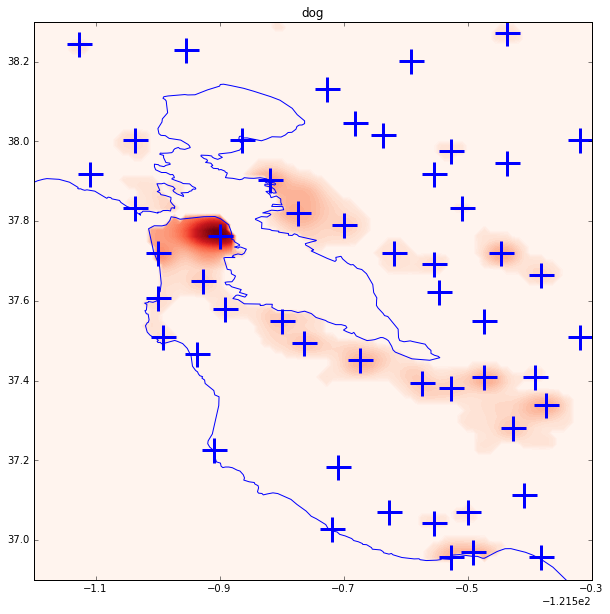

In [183]:
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  plot contours of the density
Z_mask = Z < 29**2.*3
Z_new = Z
Z_new[Z_mask] = 0
levels = np.linspace(0, np.log10(Z_new.max()), 50)
levels = np.linspace(0, np.sqrt(Z_new.max()), 50)
plt.contourf(X, Y, np.sqrt(Z_new), levels=levels, cmap=plt.cm.Reds)
#
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.7,38.5) 
plt.title(keyword)
#
plt.show()

[20.0, 23.0, 18.0, 36.0, 15.0, 41.0, 42.0, 38.0, 21.0, 26.0, 19.0, 34.0, 31.0, 39.0, 40.0, 17.0, 50.0, 52.0, 25.0, 22.0, 28.0, 10.0, 29.0, 24.0, 33.0, 1.0, 37.0, 11.0, 48.0, 46.0, 2.0, 16.0, 3.0, 14.0, 5.0]


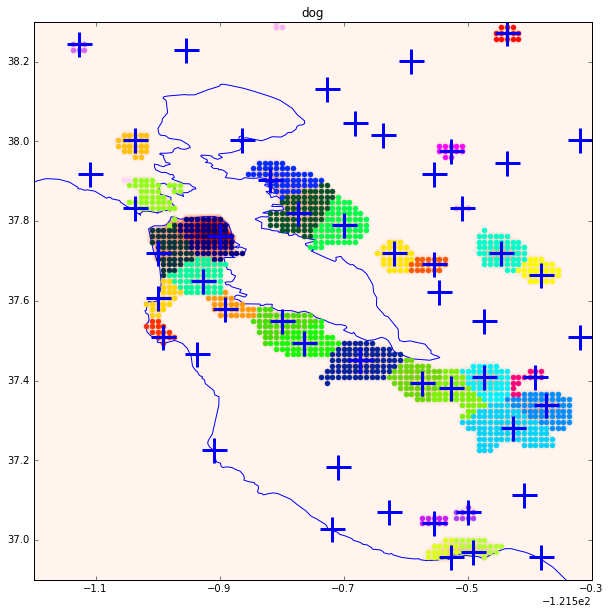

In [184]:
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  plot contours of the density
Z_mask = Z < 29**2.*3
Z_new = Z
Z_new[Z_mask] = 0
levels = np.linspace(0, np.log10(Z_new.max()), 50)
levels = np.linspace(0, np.sqrt(Z_new.max()), 50)
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.7,38.5) 
plt.title(keyword)
#
def getKey(item):
    return item[1]

int_list_sorted = sorted(int_list, key=getKey,reverse=True)


use_list = []
value_list = []
for idx,item in enumerate(int_list_sorted):
    if idx < 100:
        if item[0] > 0.0:
            use_list.append(item[0])
        else:
            pass


# Black removed and is used for noise instead.
unique_labels = use_list
print(unique_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
colors = plt.cm.gist_ncar(np.linspace(0, 1, len(unique_labels)))
# colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for tmp_label in unique_labels:
    
#     tmp_mask = peaks_mask == tmp_label
    
#     tmp_coords = np.vstack([Y[tmp_mask].ravel(),X[tmp_mask].ravel()]).T
# #     plt.plot(tmp_coords[:,1],tmp_coords[:,0], tmp_label, markerfacecolor=col,
# #              markeredgecolor=col, markersize=5)
    
#     for idx,position in enumerate(tmp_coords[:,1]):
#         tmp_x = position
#         tmp_y = tmp_coords[idx,0]
#         print(tmp_x,tmp_y)
# #         plt.annotate(tmp_label, xy=(tmp_x,tmp_y),  xycoords='data',
# #                     xytext=(0.8, 0.95), textcoords='data')    
    
    
for k, col in zip(unique_labels, colors):
    
    # get data
    class_member_mask = (node_mask == k)
    tmp_coords = np.vstack([X[class_member_mask].ravel(),Y[class_member_mask].ravel()]).T

    plt.plot(tmp_coords[:,0],tmp_coords[:,1], 'o', mfc=col,
             markeredgecolor=col,markersize=5)

    
plt.contourf(X, Y, np.sqrt(Z_new), levels=levels, cmap=plt.cm.Reds)
#
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
    
plt.show()
